# Housing Sale Prediction

In [342]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, f_regression, chi2
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt

# Variables

In [343]:
SUBMISSION_VERSION = "v2"
MAX_CARDINALITY = 11

## 1. Data Import and Basic Preprocessing

### 1.1 Data Loading and Check for NAN

In [344]:
train_df = pd.read_csv('../data/housing/train.csv', keep_default_na=False, index_col='Id')
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [345]:
train_df.dtypes.unique()

array([dtype('int64'), dtype('O')], dtype=object)

In [346]:
train_df.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64

In [347]:
test_df = pd.read_csv('../data/housing/test.csv', keep_default_na=False, index_col='Id')
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,Inside,...,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1462,20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74,13830,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
1464,60,RL,78,9978,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,6,2010,WD,Normal
1465,120,RL,43,5005,Pave,NA,IR1,HLS,AllPub,Inside,...,144,0,NA,NA,NA,0,1,2010,WD,Normal


In [348]:
len(test_df)

1459

In [349]:
test_df.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64

In [350]:
test_df.dtypes

MSSubClass        int64
MSZoning         object
LotFrontage      object
LotArea           int64
Street           object
                  ...  
MiscVal           int64
MoSold            int64
YrSold            int64
SaleType         object
SaleCondition    object
Length: 79, dtype: object

### 1.3 Replacing numerical_cols NA Values with 0

Looks like this is being caused by the fact there are some entries which have NA, which I assume apply to houses that don't meet the criteria ie. if you don't have a Masonry Veneer then this is being recorded as NA. I am going to preprocess this so all numerical dtypes which have NA entries replace these with 0, as having zero area is the same thing has not having that feature in your property.

In [351]:
actual_numerical_cols = ['LotFrontage', 'LotArea', 'Fireplaces', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                         '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                         'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'TotalBsmtSF', 'BsmtUnfSF',
                         'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

In [352]:
train_df_incorrect_numerical_types = [cname for cname in actual_numerical_cols if train_df[cname].dtype == object]
train_df_incorrect_numerical_types

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [353]:
train_df[train_df_incorrect_numerical_types] = train_df[train_df_incorrect_numerical_types].replace({'NA': 0}).astype(int)
train_df[actual_numerical_cols].dtypes

LotFrontage      int64
LotArea          int64
Fireplaces       int64
YearBuilt        int64
YearRemodAdd     int64
MasVnrArea       int64
BsmtFinSF1       int64
BsmtFinSF2       int64
1stFlrSF         int64
2ndFlrSF         int64
LowQualFinSF     int64
GrLivArea        int64
BsmtFullBath     int64
BsmtHalfBath     int64
FullBath         int64
HalfBath         int64
Fireplaces       int64
GarageYrBlt      int64
GarageCars       int64
GarageArea       int64
WoodDeckSF       int64
TotalBsmtSF      int64
BsmtUnfSF        int64
OpenPorchSF      int64
EnclosedPorch    int64
3SsnPorch        int64
ScreenPorch      int64
PoolArea         int64
MiscVal          int64
MoSold           int64
YrSold           int64
dtype: object

In [354]:
test_df_incorrect_numerical_types = [cname for cname in actual_numerical_cols if test_df[cname].dtype == object]
test_df_incorrect_numerical_types

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 'BsmtUnfSF']

In [355]:
test_df[test_df_incorrect_numerical_types] = test_df[test_df_incorrect_numerical_types].replace({'NA': 0}).astype(int)
test_df[test_df_incorrect_numerical_types].dtypes

LotFrontage     int64
MasVnrArea      int64
BsmtFinSF1      int64
BsmtFinSF2      int64
BsmtFullBath    int64
BsmtHalfBath    int64
GarageYrBlt     int64
GarageCars      int64
GarageArea      int64
TotalBsmtSF     int64
BsmtUnfSF       int64
dtype: object

### 1.4 Replacing Ordinal NA Values

In [356]:
ordinal_cols = ['LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond']
#potential_ordinal_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure',
         #       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
         #       'PoolQC', 'Fence']

## 2. Initial Model Training

Intend to use a simple pipeline with numerical and categorical encoder to get initial MAE, then look to improve model results.

In [357]:
def y_and_train_test_split(df: pd.DataFrame, y_column: str, train_size: float):
    """_summary_

    Args:
        df (pd.DataFrame): _description_
        train_size (float): _description_
    """
    test_size = 1.0 - train_size
    X_final = df.drop(y_column, axis=1)
    y = df[y_column]
    return train_test_split(X_final, y,
                            train_size=train_size, test_size=test_size,
                            random_state=0)

### 2.1 Create test_train split

In [358]:
y_column = 'SalePrice'
X_train, X_valid, y_train, y_valid = y_and_train_test_split(train_df, y_column, 0.8)

### 2.2 Generating Categorical and Numerical col_names

These will be passed to the Pipeline encoders.

In [359]:
categorical_cols = [cname for cname in X_train.columns
                    if X_train[cname].nunique() < MAX_CARDINALITY and
                    X_train[cname].dtype == "object" and
                    test_df[cname].nunique() < MAX_CARDINALITY and
                    test_df[cname].dtype == "object"]

In [360]:
numerical_cols = [cname for cname in X_train.columns
                  if X_train[cname].dtype in ['int64', 'float64'] and
                  test_df[cname].dtype in ['int64', 'float64']]

In [361]:
full_cols = categorical_cols + numerical_cols
X_train = X_train[full_cols].copy()
X_valid = X_valid[full_cols].copy()
X_test = test_df[full_cols].copy()

### 2.3 Preprocess and Train Model

Define the numerical and categorical encoders.

In [362]:
numerical_transformer = SimpleImputer(strategy='constant')


In [363]:
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [364]:
column_transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [365]:
pipeline1 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(
            n_estimators=75,
            random_state=0))
    ]
)

In [366]:
pipeline1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbvGr...
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', 'FireplaceQu',
                                                   'GarageType', 'GarageFinish',
                                                   'GarageQual', ...]),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['LandSlope', 'OverallQual',
                                                   'OverallCond', 'ExterQual',
                                                   'ExterCond'])])),
                ('model',
                 RandomForestRegressor(n_estimators=75, random_state=0))])

In [367]:
preds = pipeline1.predict(X_valid)

In [368]:
mea1 = mean_absolute_error(y_valid, preds)
mea1

17361.97538812786

In [369]:
rmse1 = root_mean_squared_error(y_valid, preds)
rmse1

33865.434361073654

### 2.4 Generate Initial Predictions

In [370]:
def output_preds(X_test: pd.DataFrame, preds_test: pd.DataFrame, version: str):
    output = pd.DataFrame({
        'Id': X_test.index,
        'SalePrice': preds_test
    })
    output.to_csv(f"submission_{version}.csv", index=False)

In [371]:
preds_test = pipeline1.predict(X_test)

In [372]:
output_preds(X_test, preds_test, 'v1')

## 3. Improved Data Preprocessing

In [382]:
def create_categorical_cols(train: pd.DataFrame,
                            test: pd.DataFrame,
                            cols_to_ignore: list[str]) -> list[str]:
    """_summary_

    Args:
        df (pd.Dataframe): _description_
        cols_to_ignore (list[str]): _description_

    Returns:
        list[str]: _description_
    """
    return [cname for cname in train.columns
            if cname not in cols_to_ignore and
            train[cname].nunique() < MAX_CARDINALITY and
            train[cname].dtype == "object" and
            test[cname].nunique() < MAX_CARDINALITY and
            test[cname].dtype == "object"]

def create_numerical_cols(train: pd.DataFrame,
                          test: pd.DataFrame,
                          cols_to_ignore: list[str]) -> list[str]:
    """_summary_

    Args:
        train (pd.DataFrame): _description_
        test (pd.DataFrame): _description_
    
    Returns:
        list[str]: _description_
    """
    return [cname for cname in train.columns
            if cname not in cols_to_ignore and
            train[cname].dtype in ['int64', 'float64'] and
            test[cname].dtype in ['int64', 'float64']]

### 3.1 Ordinal Encoding

There appears to be quite alot of ordinal data which isn't being encoded properly. I will not add a preprocessor stage for these columns in an attempt to improve model accuracy. 

There are some columns which have Ordinal Rankings which are dependant on other factors, such as BsmtQual, which ranks Po to Ex if there is a basement, or NA if a basement doesn't exist. I intend to include these in ordinal_columns for this regression and will review the results.

I am also going to have to 

In [383]:
y_column = 'SalePrice'
X_train, X_valid, y_train, y_valid = y_and_train_test_split(train_df, y_column, 0.8)

In [384]:
ordinal_cols = ['LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond']
#potential_ordinal_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure',
         #       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
         #       'PoolQC', 'Fence']

In [385]:
ordinal_transformer = Pipeline(
    steps=[
        ('ordinal', OrdinalEncoder())
    ]
)

### 3.2 Recreate categorical_cols and numerical_cols

In [386]:
categorical_cols = create_categorical_cols(X_train, test_df, ordinal_cols)

In [387]:
numerical_cols = create_numerical_cols(X_train, test_df, ordinal_cols)

In [388]:
full_cols = ordinal_cols + categorical_cols + numerical_cols
X_train = X_train[full_cols].copy()
X_valid = X_valid[full_cols].copy()
X_test = test_df[full_cols].copy()

## 4. Updated Model Training

### 4.1 New Preprocessor and Model Definition

In [389]:
column_transformer_updated = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols)
    ]
)

In [390]:
pipeline2 = Pipeline(
    steps=[
        ('column_transformer', column_transformer_updated),
        ('variance_threshold', VarianceThreshold(threshold=0.0)),
        ('select_percentile', SelectPercentile(chi2, percentile=95)),
        ('model', RandomForestRegressor(
            n_estimators=100,
            random_state=0))
    ]
)

### 4.2 Hyperparameter Tuning

In [408]:
param_grid = {
    'model__n_estimators': [50, 60, 70, 80, 90, 100, 125, 150]
}

grid_search = GridSearchCV(pipeline2,
                           param_grid=param_grid,
                           n_jobs=2)

In [409]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

/home/mbarbaric/dev/python/kaggle/venv_kaggle/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mbarbaric/dev/python/kaggle/venv_kaggle/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 977, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/mbarbaric/dev/python/kaggle/venv_kaggle/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 415, in __call__
    return estimator.score(*args, **kwargs)
  File "/home/mbarbaric/dev/python/kaggle/venv_kaggle/lib/python3.10/site-packages/sklearn/pipeline.py", line 993, in score
    Xt = transform.transform(Xt)
  File "/home/mbarbaric/dev/python/kaggle/venv_kaggle/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 273, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  F

{'model__n_estimators': 50}

In [ ]:
pipeline2 = Pipeline(
    steps=[
        ('column_transformer', column_transformer_updated),
        ('variance_threshold', VarianceThreshold(threshold=0.0)),
        ('select_percentile', SelectPercentile(chi2, percentile=95)),
        ('model', RandomForestRegressor(
            n_estimators=50,
            random_state=0))
    ]
)

In [ ]:
pipeline_optimized.fit(X_train, y_train)
preds_2 = pipeline_optimized.predict(X_valid)

In [ ]:
mea2 = mean_absolute_error(y_valid, preds_2)
mea2

In [ ]:

rmse2 = root_mean_squared_error(y_valid, preds_2)
rmse2

### 4.2 Training and Evaluation

In [391]:
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'Bedroo...
                                                   'GarageType', 'GarageFinish',
                                                   'GarageQual', ...]),
                                                 ('ord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['LandSlope', 'OverallQual',
                                                   'OverallCond', 'ExterQual',
                                                   'ExterCond'])])),
                ('variance_threshold', VarianceThreshold()),
                ('select_percentile',
                 SelectPercentile(percentile=95,
                                  score_func=<function chi2 at 0x7f6549a73520>)),
                ('model', RandomForestRegressor(random_state=0))])

In [392]:
pred_updated = pipeline2.predict(X_valid)

In [393]:
mea3 = mean_absolute_error(y_valid, pred_updated)
mea3

17573.318493150684

In [394]:
rmse3 = root_mean_squared_error(y_valid, pred_updated)
rmse3

33778.11190548671

In [395]:
preds_test_updated = pipeline2.predict(X_test)

In [396]:
output_preds(X_test, preds_test_updated, 'v2')

### 4.3 Model Comparison

In [397]:
model_comparison = pd.DataFrame([['v1', mea, rmse], ['v2', mea2, rmse2], ['v3', mea3, rmse3]], columns=['model_version', 'mea', 'rmse'])
model_comparison

,model_version,mea,rmse
0,v1,17321.638425,33874.954993
1,v2,17321.638425,33874.954993
2,v3,17573.318493,33778.111905


## 5 Model Evaluation

### 5.1 Check for missing columns

In [398]:
missing_cols = [cname for cname in test_df.columns if cname not in full_cols]
missing_cols

['Neighborhood', 'Exterior1st', 'Exterior2nd']

### 5.3 Feature Importances

In [399]:
model = pipeline2['model']
column_transformer = pipeline2['column_transformer']
select_percentile = pipeline2['select_percentile']

In [403]:
feature_importances = model.feature_importances_
original_feature_names = column_transformer.get_feature_names_out()
feature_names = [original_feature_names[i] for i, _name in enumerate(select_percentile.get_feature_names_out())]

In [404]:
print(f"feature_importances: {len(feature_importances)}, feature_names: {len(feature_names)}")

feature_importances: 222, feature_names: 222


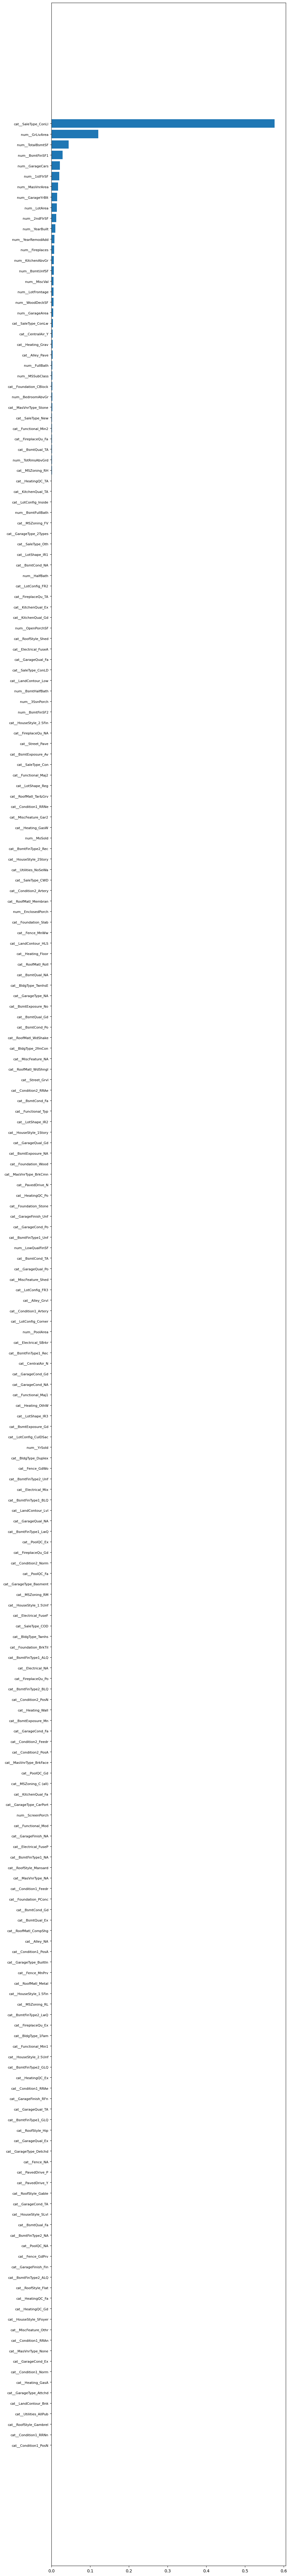

In [406]:
f_i = list(zip(feature_names, feature_importances))
f_i.sort(key=lambda x: x[1])
plt.figure(figsize=[10, 110])
plt.barh([x[0] for x in f_i], [x[1] for x in f_i])
plt.yticks(fontsize=8)
plt.show()

### Evaluation Points

* 1. Improved Feature Selection: there are over 200 features currently which is far too complicated. Need to reduce.
* 2. Replacing some Ordinal Encoding with Binary Encoding: there are certain values which are currently being treated as Ordinal values which could be replaced by Binary Encoding (MiscFeature, Fence). 
* 3. Model Selection: use GradientBoostedTrees or another model instead of RandomForrest.